In [109]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from utils import load_data
import cv2 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from typing import Union

In [110]:
names, images, segmentations, bounding_boxes = load_data('train.pkl')

100%|██████████| 65/65 [00:00<00:00, 442.99it/s]


In [3]:
def get_bb_pts(bounding_box: Union[np.ndarray, torch.Tensor], flatten=False):
    """
    Retrieves boundign box coordinates from bounding box mask.

    Args: 
        bounding_box (np.ndarray | torch.Tensor) : mask of 0s and 1s, wher 1s indicate pixels inside the bounding box

    Returns:
        List (if flatten is False) or Tensor or NdArray of bounding box coordniates

    """
    bb = bounding_box
    if isinstance(bb, np.ndarray):
        bounding_box_indices = np.argwhere(bb)
    elif isinstance(bb, torch.Tensor):
        if bb.ndim ==3:
            bb = bb.squeeze(0)
        bounding_box_indices = torch.argwhere(bb)
        
    else:
        raise Exception('object type is not a ndarray or tensor ')
    top_left = bounding_box_indices.min(axis=0)  # (min_row, min_col)
    bottom_right = bounding_box_indices.max(axis=0)  # (max_row, max_col)
    transform = lambda obj : np.array(obj) if isinstance(obj, np.ndarray)  else torch.tensor(obj)

    if isinstance(bb, torch.Tensor):
        top_left = top_left.values
        bottom_right = bottom_right.values

    if flatten:
        return transform([*top_left, *bottom_right])
    return [top_left, bottom_right]

def list_to_tensor(lst:list[torch.Tensor]):
    """
    Converts a list of tensors into a single tensor

    Args:
        lst (lst[torch.Tesnor]): a list of tensors
    Returns:
        Tensor
    """
    return torch.from_numpy(np.array(lst))

def show_image(image, bb_pts):
    """Show image with landmarks"""

    fig, ax = plt.subplots(figsize=(8, 8))
    print(bb_pts)


    plt.imshow(image)

    top_left = bb_pts[0]
    bottom_right = bb_pts[1]


    rect = Rectangle(
        (top_left[1], top_left[0]),  # (x, y): (col, row)
        bottom_right[1] - top_left[1] + 1,  # width
        bottom_right[0] - top_left[0] + 1,  # height
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [111]:
bb_pts = [get_bb_pts(bb) for bb in bounding_boxes]
bounding_boxes = [bb.astype(float) for bb in bounding_boxes]

In [112]:
print(torch.from_numpy( bounding_boxes[0]).shape)

get_bb_pts(torch.from_numpy(bounding_boxes[0]), flatten=True), get_bb_pts(bounding_boxes[0])

torch.Size([112, 112])


(tensor([70, 50, 97, 93], device='mps:0'), [array([70, 50]), array([97, 93])])

[array([70, 50]), array([97, 93])]


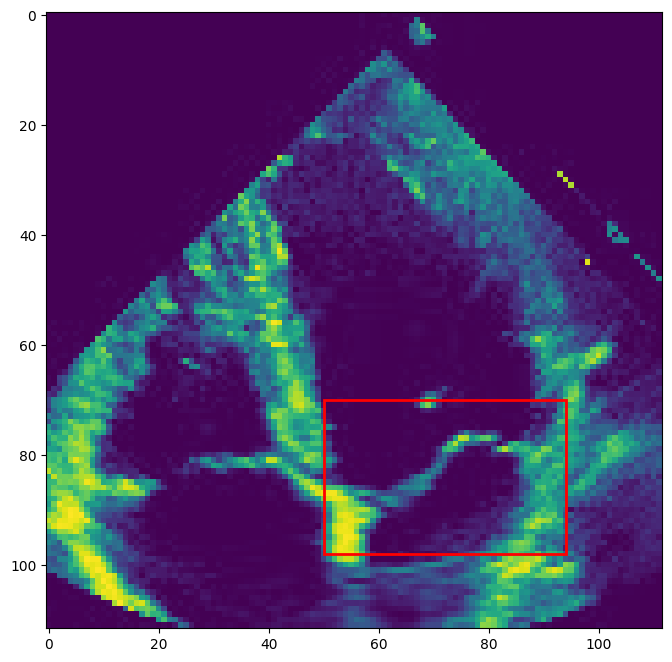

In [113]:
show_image(images[0], bb_pts[0])

In [114]:
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class CustomImageDataset(Dataset):
    def __init__(self, images, bbs, transform=None):
        super().__init__()

        self.images = images
        self.bbs = bbs 
        self.transform = transform 

    def __getitem__(self, index):
        image = self.images[index]
        bbs = self.bbs[index]
      
        sample = {'img':image, 'bb': bbs}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample
    
    def __len__(self):
        return len(self.images)



In [ ]:
from torchvision import transforms, datasets
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, bounding_boxes = sample['img'], sample['bb']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        bounding_boxes = transform.resize(bounding_boxes, (new_h, new_w))

        return {'img': img,'bb' :bounding_boxes}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, bounding_boxes =  sample['img'], sample['bb']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        bounding_boxes = bounding_boxes[top: top + new_h,
                      left: left + new_w]

        return {'img': image,'bb' :bounding_boxes}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bounding_boxes = sample['img'], sample['bb']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        return {'img':torch.from_numpy(image),'bb': torch.from_numpy(bounding_boxes)}
    
class Normalize(object):

    def __init__(self, mean:list, std:list):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, bounding_boxes = sample['img'], sample['bb']

        if image.ndim ==2:
            image = torch.unsqueeze(image, 0)
            bounding_boxes = torch.unsqueeze(bounding_boxes, 0)

        

        noramlizer = transforms.Normalize(self.mean, self.std)

        return {'img': F.relu(noramlizer(image)), 'bb': bounding_boxes}
    
class RandomFlip(object):

    def __init__(self, p:float):
        self.p = p

    def __call__(self, sample):
        image, bounding_boxes = sample['img'], sample['bb']

        if image.ndim ==2:
            image = torch.unsqueeze(image, 0)
            bounding_boxes = torch.unsqueeze(bounding_boxes, 0)

        
        flipper = transforms.RandomHorizontalFlip(self.p)

        return {'img': flipper(image), 'bb': flipper(bounding_boxes)}
    

In [116]:
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, bounding_boxes, test_size=0.2)
train_dataset = CustomImageDataset(images= X_train, 
                                   bbs= y_train, 
                                   transform=transforms.Compose([
                                               Rescale((224, 224)),
                                            #    RandomCrop(224),
                                               ToTensor(),
                                               RandomFlip(0.33),
                                               Normalize(mean=[0.485,], std=[0.229,])
                                           ]))
test_dataset = CustomImageDataset(images= X_test, 
                                   bbs= y_test, 
                                   transform=transforms.Compose([
                                               Rescale((224, 224)),
                                               ToTensor(),
                                              #  Normalize(mean=[0.485,], std=[0.229,])
                                           ]))



In [117]:
len(X_train), len(X_test)

(156, 39)

In [118]:
for i, sample in enumerate(train_dataset):
    print(i, sample['img'].size(), sample['bb'].size())

    if i == 3:
        break

0 torch.Size([1, 224, 224]) torch.Size([1, 224, 224])
1 torch.Size([1, 224, 224]) torch.Size([1, 224, 224])
2 torch.Size([1, 224, 224]) torch.Size([1, 224, 224])
3 torch.Size([1, 224, 224]) torch.Size([1, 224, 224])


In [ ]:
import torch
import torch.nn as nn


class Conv3x3(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding=1, bias=False):
        super().__init__()

        self.filter = nn.Conv2d(
            in_channels, out_channels, 3, stride, padding=padding, bias=bias)
    def bias(self):
        return filter.weight.bias
    def shape(self):
        return filter.weigth.shape

    def forward(self, x):
        return self.filter(x)


class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=None, bias=False):
        super().__init__()

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        initial_stride = 1

        if downsample:
            initial_stride = 2

        # groups = min(32, out_channels)  # Choose the smaller value
        
        self.c1 = Conv3x3(in_channels, out_channels, initial_stride, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.c2 = Conv3x3(out_channels, out_channels, stride, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # self.c = nn.Sequential(
        #     self.c1,
        #     self.gn1,
        #     self.relu,
        #     self.c2,
        #     self.gn2
        # )

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)
        # pre-activation 1
        out = self.c1(x)
        out = self.bn1(out)

        
        # post-activation 1
        out = self.relu(out)


        # pre-activation 2
        out = self.c2(out)
        out = self.bn2(out)


        # post-activation 2
        out = self.relu(out + identity)
        return out
    
    def shape(self):
        return self.c1.shape


class ResNet(nn.Module):

    def __init__(self):
        super(ResNet, self).__init__()
        self.con1_sz = 7

        self.conv1 = nn.Conv2d(1, 64, self.con1_sz, stride=2, padding=3, bias=False)

        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2_x = self._make_convN_x(
            64, 64, downsample=None, n_blocks=3)
        self.conv3_x = self._make_convN_x(64, 128, 2, 4)
        self.conv4_x = self._make_convN_x(128, 256, 2, 6)
        self.conv5_x = self._make_convN_x(256, 512, 2, 3)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 4)

    def _make_convN_x(self, in_channels, out_channels, downsample, n_blocks):
        head = DoubleConvBlock(in_channels, out_channels, stride=1,
                               downsample=downsample, bias=False)

        layers = [head] + [DoubleConvBlock(
            out_channels,
            out_channels,
            stride=1,
            bias=False) for _ in range(n_blocks - 1)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)

        x = self.conv2_x(x)

        x = self.conv3_x(x)

        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avg_pool(x)

        x = x.view(x.size(0), -1) 
        x = self.fc(x)

        return x


In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
class BBIoU(nn.Module):

    def __init__(self):
        super(BBIoU, self).__init__()

    def forward(self, pred, target):
        bb_pred = pred
        bb_ground_truth = target

        # assert that x2 > x1 and y2 > y1
        bb_pred[:,  0], bb_pred[:, 2] = torch.cat([bb_pred[:,  0:1], bb_pred[:, 2:3]], dim=1).min(dim=1)[0] ,torch.cat([bb_pred[:,  0:1], bb_pred[:, 2:3]], dim=1).max(dim=1)[0]
        bb_pred[:,  1], bb_pred[:, 3] = torch.cat([bb_pred[:,  1:2], bb_pred[:, 3:4]], dim=1).min(dim=1)[0] , torch.cat([bb_pred[:,  1:2], bb_pred[:, 3:4]], dim=1).max(dim=1)[0]


        
         # Determine the (x, y)-coordinates of the intersection rectangle
        xA = torch.cat((bb_pred[:, 0:1], bb_ground_truth[:, 0:1]), 1).max(
            dim=1)[0].unsqueeze(1)
        yA = torch.cat((bb_pred[:, 1:2], bb_ground_truth[:, 1:2]), 1).max(
            dim=1)[0].unsqueeze(1)
        xB = torch.cat((bb_pred[:, 2:3], bb_ground_truth[:, 2:3]), 1).min(
            dim=1)[0].unsqueeze(1)
        yB = torch.cat((bb_pred[:, 3:4], bb_ground_truth[:, 3:4]), 1).min(
            dim=1)[0].unsqueeze(1)

        

        # Compute the area of intersection rectangle
        inter_x_len = F.relu(xB - xA)
        inter_y_len = F.relu(yB - yA)
        # Negative area means no overlap
        interArea = inter_x_len * inter_y_len


        # Compute the area of convex hull rectangle

        # If you don't have xyhw values, calculate areas like this
        w1 = (bb_pred[:, 0:1] - bb_pred[:, 2:3]).abs()
        h1 = (bb_pred[:, 1:2] - bb_pred[:, 3:4]).abs()

        w2 = (bb_ground_truth[:, 0:1] - bb_ground_truth[:, 2:3]).abs()
        h2 = (bb_ground_truth[:, 1:2] - bb_ground_truth[:, 3:4]).abs()


        area1 = w1 * h1
        area2 = w2 * h2

        iou = interArea / (area1 + area2 - interArea + 1e-5)

        return iou
         

In [119]:
class GIoU(nn.Module):

    def __init__(self):
        super(GIoU, self).__init__()

    def forward(self, pred, target):
        bb_pred = pred
        bb_ground_truth = target

        # assert that x2 > x1 and y2 > y1
        bb_pred[:,  0], bb_pred[:, 2] = torch.cat([bb_pred[:,  0:1], bb_pred[:, 2:3]], dim=1).min(dim=1)[0] ,torch.cat([bb_pred[:,  0:1], bb_pred[:, 2:3]], dim=1).max(dim=1)[0]
        bb_pred[:,  1], bb_pred[:, 3] = torch.cat([bb_pred[:,  1:2], bb_pred[:, 3:4]], dim=1).min(dim=1)[0] , torch.cat([bb_pred[:,  1:2], bb_pred[:, 3:4]], dim=1).max(dim=1)[0]


        
         # Determine the (x, y)-coordinates of the intersection rectangle
        xA = torch.cat((bb_pred[:, 0:1], bb_ground_truth[:, 0:1]), 1).max(
            dim=1)[0].unsqueeze(1)
        yA = torch.cat((bb_pred[:, 1:2], bb_ground_truth[:, 1:2]), 1).max(
            dim=1)[0].unsqueeze(1)
        xB = torch.cat((bb_pred[:, 2:3], bb_ground_truth[:, 2:3]), 1).min(
            dim=1)[0].unsqueeze(1)
        yB = torch.cat((bb_pred[:, 3:4], bb_ground_truth[:, 3:4]), 1).min(
            dim=1)[0].unsqueeze(1)
        
        # convex hull
        xC = torch.cat((bb_pred[:, 0:1], bb_ground_truth[:, 0:1]), 1).min(
            dim=1)[0].unsqueeze(1)
        yC = torch.cat((bb_pred[:, 1:2], bb_ground_truth[:, 1:2]), 1).min(
            dim=1)[0].unsqueeze(1)
        xD = torch.cat((bb_pred[:, 2:3], bb_ground_truth[:, 2:3]), 1).max(
            dim=1)[0].unsqueeze(1)
        yD = torch.cat((bb_pred[:, 3:4], bb_ground_truth[:, 3:4]), 1).max(
            dim=1)[0].unsqueeze(1)
        
        # print(bb_pred[0], bb_ground_truth[0])

        # Compute the area of intersection rectangle
        inter_x_len = F.relu(xB - xA)
        inter_y_len = F.relu(yB - yA)
        # Negative area means no overlap
        interArea = inter_x_len * inter_y_len


        # Compute the area of convex hull rectangle
        hull_x_len = (xD - xC)
        hull_y_len = (yD - yC)
        hullArea = hull_x_len * hull_y_len

        # If you don't have xyhw values, calculate areas like this
        w1 = (bb_pred[:, 0:1] - bb_pred[:, 2:3]).abs()
        h1 = (bb_pred[:, 1:2] - bb_pred[:, 3:4]).abs()

        w2 = (bb_ground_truth[:, 0:1] - bb_ground_truth[:, 2:3]).abs()
        h2 = (bb_ground_truth[:, 1:2] - bb_ground_truth[:, 3:4]).abs()


        area1 = w1 * h1
        area2 = w2 * h2

        iou = interArea / (area1 + area2 - interArea + 1e-5)

        giou = iou  - (hullArea - interArea)/ hullArea
        return 1 - giou
         

In [120]:
learning_rate = 1e-3
batch_size = 4
epochs = 50

In [121]:
train_data_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=0 )
test_data_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=True, num_workers=0 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.2489082969432315].


0 torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224])
1 torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224])
2 torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224])
3 torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224])


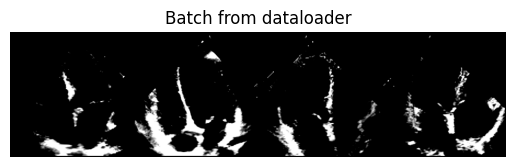

In [ ]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, bb_batch = \
            sample_batched['img'], sample_batched['bb']
    if images_batch.ndim == 3:
        images_batch = torch.unsqueeze(images_batch, 1)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_data_loader):
    print(i_batch, sample_batched['img'].size(),
          sample_batched['bb'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


In [139]:
train_dataset[0]

{'img': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64),
 'bb': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64)}

In [140]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

model = ResNet()

In [142]:
def get_nested_attr(obj, attr_path):
    """Retrieve a nested attribute from an object."""
    attrs = attr_path.split(".")
    for attr in attrs:
        obj = getattr(obj, attr)
    return obj

def set_nested_attr(obj, attr_path, value):
    """Set a nested attribute on an object."""
    attrs = attr_path.split(".")
    for attr in attrs[:-1]:
        obj = getattr(obj, attr)
    setattr(obj, attrs[-1], value)


In [143]:
for name, module in model.named_modules():
    if isinstance(module, nn.BatchNorm2d):
        # Get current bn layer
        bn = get_nested_attr(model, name)
        # Create new gn layer
        gn = nn.GroupNorm(2, bn.num_features)
        # Assign gn
        print('Swapping {} with {}'.format(bn, gn))
        set_nested_attr(model, name, gn)
# initialize_weights(model)

Swapping BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) with GroupNorm(2, 64, eps=1e-05, affine=True)
Swapping BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) with GroupNorm(2, 64, eps=1e-05, affine=True)
Swapping BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) with GroupNorm(2, 64, eps=1e-05, affine=True)
Swapping BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) with GroupNorm(2, 64, eps=1e-05, affine=True)
Swapping BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) with GroupNorm(2, 64, eps=1e-05, affine=True)
Swapping BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) with GroupNorm(2, 64, eps=1e-05, affine=True)
Swapping BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) with GroupNorm(2, 128, eps=1e-05, affine=True)
Swapping BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [ ]:
# # Check that MPS is available
# if not torch.backends.mps.is_available():
#     if not torch.backends.mps.is_built():
#         print("MPS not available because the current PyTorch install was not "
#               "built with MPS enabled.")
#     else:
#         print("MPS not available because the current MacOS version is not 12.3+ "
#               "and/or you do not have an MPS-enabled device on this machine.")
# else:
#     print("successfully model to device ")
#     mps_device = torch.device("mps")
#     model.to(mps_device)
#     torch.device(mps_device)

successfully model to device 


In [144]:
torch.set_default_device('cpu')
torch.get_default_device()

device(type='cpu')

In [145]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, sample in enumerate(dataloader):
        # Compute prediction and loss
        X = sample['img'] 
        y = list_to_tensor([get_bb_pts(bb, flatten=True) for bb in torch.unbind(sample['bb'], dim=0)])
        X, y = X.to(torch.float32), y.to(torch.float32)
        pred = model(X)
        loss = loss_fn(pred, y).sum()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 8 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, eval_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for sample in dataloader:
            X = sample['img'] 
            y = list_to_tensor([get_bb_pts(bb, flatten=True) for bb in torch.unbind(sample['bb'], dim=0)])
            X, y = [t.to(torch.float32) for t in [X,y]]
            if X.ndim == 3:
                X = torch.unsqueeze(X, 1)
            pred = model(X)
            print(pred, y)
            test_loss += loss_fn(pred, y).sum().item()
            accuracy += eval_fn(pred, y).sum().item()

    test_loss /= num_batches
    accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [146]:
len(X_test), len(X_train), len(images)

(39, 156, 195)

In [147]:
loss_fn = nn.MSELoss()
eval_fn = BBIoU()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_data_loader, model, loss_fn, optimizer)
    test_loop(test_data_loader, model, loss_fn, eval_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 19471.833984  [    4/  156]
loss: 10844.712891  [   36/  156]
loss: 11443.642578  [   68/  156]
loss: 10562.541016  [  100/  156]
loss: 5909.416992  [  132/  156]
tensor([[48.7991, 42.4047, 55.1859, 57.7719],
        [48.7991, 42.4047, 55.1859, 57.7720],
        [48.7991, 42.4047, 55.1859, 57.7719],
        [48.7991, 42.4047, 55.1859, 57.7720]]) tensor([[ 99.,  85., 152., 172.],
        [ 82., 103., 131., 159.],
        [123.,  79., 186., 160.],
        [113.,  95., 168., 182.]])
tensor([[48.7991, 42.4046, 55.1859, 57.7720],
        [48.7990, 42.4047, 55.1859, 57.7720],
        [48.7991, 42.4047, 55.1859, 57.7719],
        [48.7991, 42.4047, 55.1859, 57.7720]]) tensor([[ 97.,  95., 150., 180.],
        [ 91., 120., 132., 169.],
        [123.,  79., 186., 160.],
        [109.,  91., 160., 168.]])
tensor([[48.7991, 42.4047, 55.1859, 57.7720],
        [48.7991, 42.4047, 55.1859, 57.7720],
        [48.7991, 42.4047, 55.1859, 57.7719],
        [

KeyboardInterrupt: 

In [71]:
for i in range (10):
    ximg, xbb = train_dataset[i]['img'] , train_dataset[i]['bb']
    xbb  = list_to_tensor([get_bb_pts(bb, flatten=True) for bb in torch.unbind(xbb, dim=0)])
    # xbb = torch.unsqueeze(xbb, 0)
    ximg = torch.unsqueeze(ximg, 0)
    ximg, xbb = [t.to(torch.float32) for t in [ximg,xbb]] 
    pred = model(ximg)
    loss = F.mse_loss((pred, xbb)
    print(loss, pred, xbb)

tensor(11415.6348, grad_fn=<MseLossBackward0>) tensor([[-0.4773,  0.5821, -0.7214, -0.7375]], grad_fn=<AddmmBackward0>) tensor([[ 83.,  43., 140., 130.]])
tensor(15477.5410, grad_fn=<MseLossBackward0>) tensor([[-0.4440,  0.6421, -0.6786, -0.8211]], grad_fn=<AddmmBackward0>) tensor([[ 60., 111., 115., 180.]])
tensor(13663.0127, grad_fn=<MseLossBackward0>) tensor([[-0.5131,  0.5314, -0.7635, -0.7574]], grad_fn=<AddmmBackward0>) tensor([[107.,  27., 166., 120.]])
tensor(14882.0039, grad_fn=<MseLossBackward0>) tensor([[-0.5104,  0.6118, -0.7163, -0.7816]], grad_fn=<AddmmBackward0>) tensor([[106.,  90., 143., 139.]])
tensor(15793.2148, grad_fn=<MseLossBackward0>) tensor([[-0.4438,  0.5319, -0.7393, -0.8243]], grad_fn=<AddmmBackward0>) tensor([[ 87., 102., 144., 155.]])
tensor(15984.9727, grad_fn=<MseLossBackward0>) tensor([[-0.4937,  0.6320, -0.7557, -0.8757]], grad_fn=<AddmmBackward0>) tensor([[102.,  86., 146., 156.]])
tensor(17553.0098, grad_fn=<MseLossBackward0>) tensor([[-0.4414,  0.56